In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Here, we will try to reproduce the work of Moroney et al, 2019<sup>[1]</sup>. We will use the `scipy.integrate` module to sove the differential equations<sup>[2]</sup>.

We start with the differential equations from Moroney's paper:

$$
\frac{\partial c_l}{\partial t} + v_l \frac{\partial c_l}{\partial z} = \frac{6 D_v \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1} - c_l) + \frac{6 D_v \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2} - c_l), \\
\frac{\partial c_{s1}}{\partial t} = -\frac{6 D_v}{\phi_{v1} d_{s1}^2} (c_{s1} - c_l), \\
\frac{\partial c_{s2}}{\partial t} = -\frac{6 D_v}{\phi_{v2} d_{s2}^2} (c_{s2} - c_l)
$$

We will use the method of lines, with these equations discretized in $z$. We have the following boundary conditions, adapted from those given in the paper:

$$
c_l(-1, t) = 0\;\;\;\;c_l(z, 0) = 0\;\;\;\;c_s(z, 0) = c_{s0}
$$

Here, we have moved the top boundary condition above the packed bed, rather than setting concentration in the liquid to zero for the first row of the model. This allows us to model extraction through the entire bed.

Moroney uses backward finite difference to discretize. This gives us two different update steps for $c_l$:

$$
\frac{\partial c_{l,0}}{\partial t} = -v_l \frac{c_{l,0}}{\Delta z} + \frac{6 D_v \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1,0} - c_{l,0}) + \frac{6 D_v \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2,0} - c_{l,0}), \\
\frac{\partial c_{l,n}}{\partial t} = -v_l \frac{c_{l,n} - c_{l,n-1}}{\Delta z} + \frac{6 D_v \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1,n} - c_{l,n}) + \frac{6 D_v \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2,n} - c_{l,n})
$$

and one update step for $c_{s1}$ and $c_{s2}$:

$$
\frac{\partial c_{s1,n}}{\partial t} = -\frac{6 D_v}{\phi_{v1} d_{s1}^2} (c_{s1,n} - c_{l,n}), \\
\frac{\partial c_{s2,n}}{\partial t} = -\frac{6 D_v}{\phi_{v2} d_{s2}^2} (c_{s2,n} - c_{l,n})
$$

Now we need to combine $c_l$, $c_{s1}$, and $c_{s2}$ into a single array. As suggested in the SciPy documentation, it is best to interleave them as:

$$
\{c_{l,0}, c_{s1,0}, c_{s2,0}, c_{l,1}, c_{s1,1}, c_{s2,1}, \ldots, c_{l,N-1}, c_{s1,N-1}, c_{s2,N-1}\}
$$

This gives a Jacobian of the form:

$$
\begin{matrix}
* & * & * & 0 & 0 & 0 & 0 & 0 & 0 \\
* & * & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
* & 0 & * & 0 & 0 & 0 & 0 & 0 & 0 \\
* & 0 & 0 & * & * & * & 0 & 0 & 0 \\
0 & 0 & 0 & * & * & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & * & 0 & * & 0 & 0 & 0 \\
0 & 0 & 0 & * & 0 & 0 & * & * & * \\
0 & 0 & 0 & 0 & 0 & 0 & * & * & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & * & 0 & * \\
0 & 0 & 0 & 0 & 0 & 0 & * & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{matrix}
$$

This is a banded Jacobian with `mu=2` and `ml=3` in the call to `odeint`.

Now we define functions for the diffusion terms:

In [3]:
def G(D_v, a_s, a_l, d_s, c_s, c_l):
    return (6. * D_v * a_s) / (a_l * d_s**2) * (c_s - c_l)

def H(D_v, phi_v, d_s, c_s, c_l):
    return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

Now we define the function that computes the update step:

In [4]:
def update(y, t, v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2):
    # Parse the interleaved data
    c_l = y[::3]
    c_s1 = y[1::3]
    c_s2 = y[2::3]
    
    # Initialize the return value
    dy_dt = np.empty_like(y)
    
    # Interleaved views of the return value
    dcl_dt = dy_dt[::3]
    dcs1_dt = dy_dt[1::3]
    dcs2_dt = dy_dt[2::3]
    
    # Compute derivatives
    dcl_dt[0] = -v_l * c_l[0] / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[0], c_l[0]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[0], c_l[0])
    dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[1:], c_l[1:]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[1:], c_l[1:])

    dcs1_dt[:] = -H(D_v1, phi_v1, d_s1, c_s1, c_l)
    dcs2_dt[:] = -H(D_v2, phi_v2, d_s2, c_s2, c_l)
    
    return dy_dt

Now we define some constants:

In [5]:
# Constants
a_l = 0.2
a_s1 = 0.5
a_s2 = 0.3

Q = 250. / (1e2)**3 / 60.
A = np.pi * (59e-3 / 2)**2
v_l = Q / (a_l * A)

L = 0.0405
N = 100
dz = L / N

d_s1 = 2.517e-5
d_s2 = 5.63e-4

h_sl1 = 5.1207e-4
h_sl2 = 1.43e-3

#D_v1 = d_s1 * h_sl1
#D_v2 = d_s2 * h_sl2

D_v1 = 2e-11 # TO DO: Replace this with the correct value
D_v2 = D_v1

phi_v1 = 0.56
phi_v2 = 0.56

c_s = 358.587

# Initial values
cl_0 = np.array([0.] * N)
cs1_0 = np.array([c_s] * N)
cs2_0 = np.array([c_s] * N)

y0 = np.empty(3 * N)
y0[::3] = cl_0
y0[1::3] = cs1_0
y0[2::3] = cs2_0

# Time
dt = 1e-3
num_t = 200*1000
t = np.linspace(0., num_t * dt, num_t)

And finally we run `odeint`:

In [6]:
sol = odeint(update, y0, t, args=(v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2), ml=3, mu=2)
sol

array([[0.00000000e+00, 3.58587000e+02, 3.58587000e+02, ...,
        0.00000000e+00, 3.58587000e+02, 3.58587000e+02],
       [1.68351312e-01, 3.58465759e+02, 3.58586758e+02, ...,
        1.69940050e-01, 3.58465760e+02, 3.58586758e+02],
       [3.33429514e-01, 3.58344616e+02, 3.58586515e+02, ...,
        3.39742173e-01, 3.58344618e+02, 3.58586515e+02],
       ...,
       [9.45515010e-03, 9.47408547e-03, 3.13255107e+02, ...,
        9.50699494e-01, 9.52600564e-01, 3.14945733e+02],
       [9.45514370e-03, 9.47407906e-03, 3.13254896e+02, ...,
        9.50698853e-01, 9.52599921e-01, 3.14945521e+02],
       [9.45513731e-03, 9.47407266e-03, 3.13254684e+02, ...,
        9.50698211e-01, 9.52599278e-01, 3.14945309e+02]])

Let's plot the results.

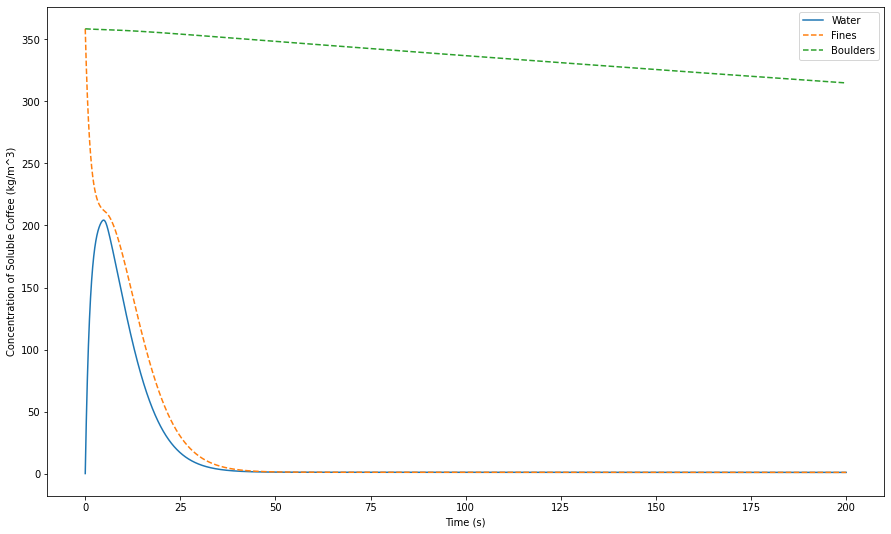

In [7]:
# Get values at the outlet
c_l = sol[:,-3]
c_s1 = sol[:,-2]
c_s2 = sol[:,-1]

# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(t, c_l, label='Water')
ax.plot(t, c_s1, '--', label='Fines')
ax.plot(t, c_s2, '--', label='Boulders')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee (kg/m^3)')

# Add a legend
plt.legend()

# References

[1] Moroney et al., 2019 \
[2] https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#solving-a-system-with-a-banded-jacobian-matrix